In [237]:
import numpy as np

import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.spatial.distance import cdist
from scipy.interpolate import RBFInterpolator
from scipy.spatial import ConvexHull
import scipy.io as scio
import scipy.sparse as sp
from sklearn.decomposition import PCA


import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import os
from importlib import reload

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches


#from wordcloud import WordCloud
import time
import re
import glob
import pickle as pkl
from scipy.spatial import Delaunay
import networkx as nx


In [31]:
# functionssss
coord2idx = lambda coord, nidx, lims : int(np.around(nidx * (coord - lims[0]) / (lims[1]-lims[0])))

In [8]:
# want to compute covariance eigendecomp across multiple observables, as a function of distance from MF such as 
#     [ecad], cell density, vx, vy, shape (eccentricity), cell-depth

# to do so, we need, for each cell, 
#    its distance relative to the morphogenetic furrow 
#    number of pixels
#    velocity (should be calculable from position)
#    ecad concentration
#    (its position in pixel space)
#    (its convex hull?)
#    (whether it is part of the MF)
#    (which ommatidia is it part of and which cell is it in the ommatidia )

# these quantities should be computed and saved in another script

# we then need to map this data onto an x-y grid (grid size (dx, dy))
# where x = 0 is the MF

# at that point we have multiple observables at each grid point
# and can calculate cov_eig

In [9]:
# load cell data

headdir = '/Users/simonfreedman/'
datdir  = '{0}/data/droso/ommatidia_data/dataset1/obs'.format(headdir)

xdist_mu  = np.load('{0}/xdist_mu.npy'.format(datdir))
ydist_mu  = np.load('{0}/ydist_mu.npy'.format(datdir))
xdist_std = np.load('{0}/xdist_std.npy'.format(datdir))
ydist_std = np.load('{0}/ydist_std.npy'.format(datdir))

npix      = np.load('{0}/npix.npy'.format(datdir))
ecad_tot  = np.load('{0}/ecad_tot.npy'.format(datdir))

pos_mu    = np.load('{0}/cell_ctr.npy'.format(datdir))

f = open('{0}/mf_idxs.pkl'.format(datdir), 'rb')   
mf_idxs = pkl.load(f)                 
f.close()

precl_idxs   = np.load('{0}/precluster_idxs.npy'.format(datdir))
cell_pix_idx = np.load('{0}/cell_pixel_idx.npy'.format(datdir))


xdist_mu     = -xdist_mu # reverse so that it goes left to right
aspect_ratio = np.load('{0}/cell_aspect_ratio.npy'.format(datdir))

f = open('{0}/cell_edge_pix.pkl'.format(datdir), 'rb')  
edge_pixels = pkl.load(f)
f.close()

# f = open('{0}/cell_edge_pix.pkl'.format(outdir), 'rb')   
# cell_edge_pix = pkl.load(cell_edge_pix, f)          
# f.close()

In [12]:
# calculate velocity...
# v_vbins_par     = [[cell_ctr[b[:,0]+1,b[:,1],1]-cell_ctr[b[:,0],b[:,1],1] for b in bi] for bi in bin_idxs5]
# v_vbins_perp    = [[cell_ctr[b[:,0]+1,b[:,1],0]-cell_ctr[b[:,0],b[:,1],0] for b in bi] for bi in bin_idxs5]

vx_mf = xdist_mu[1:]-xdist_mu[:1]
vy_mf = ydist_mu[1:]-ydist_mu[:1]

v_lab = pos_mu[1:]-pos_mu[:1]

mf_pos       = np.dstack([xdist_mu, ydist_mu])
nt, ntracks  = vx_mf.shape

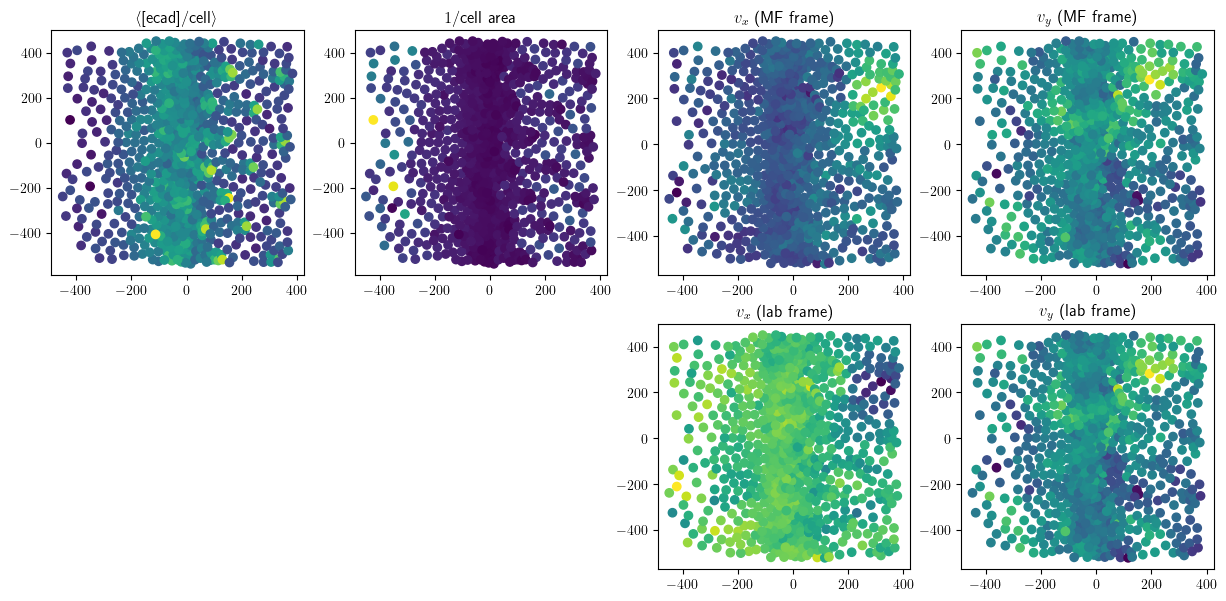

In [13]:
fig,axs=plt.subplots(2,4,figsize=(15,7))
t = 1
axs[0,0].scatter(xdist_mu[t], ydist_mu[t], c= ecad_tot[t]/npix[t])
axs[0,1].scatter(xdist_mu[t], ydist_mu[t], c= npix[t])
axs[0,2].scatter(xdist_mu[t], ydist_mu[t], c= vx_mf[t])
axs[0,3].scatter(xdist_mu[t], ydist_mu[t], c= vy_mf[t])


axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
axs[1,2].scatter(xdist_mu[t], ydist_mu[t], c= v_lab[t,:,0])
axs[1,3].scatter(xdist_mu[t], ydist_mu[t], c= v_lab[t,:,1])

axs[0,0].set_title(r'$\langle$[ecad]/cell$\rangle$')
axs[0,1].set_title(r'$1/$cell area')
axs[0,2].set_title(r'$v_x$ (MF frame)')
axs[0,3].set_title(r'$v_y$ (MF frame)')

axs[1,2].set_title(r'$v_x$ (lab frame)')
axs[1,3].set_title(r'$v_y$ (lab frame)')


plt.show()

In [14]:
t = 1
idxs        = ~np.isnan(ecad_tot[t])
idxsv       = ~np.isnan(vx_mf[t])
avg_size    = np.nanmean(npix[t,idxs])
kernel_type = 'linear'
avg_size    = 50/avg_size

ecad_rbf = RBFInterpolator(mf_pos[t,idxs], ecad_tot[t,idxs]/npix[t,idxs], kernel = kernel_type, epsilon = avg_size)
dens_rbf = RBFInterpolator(mf_pos[t,idxs], 1/npix[t,idxs],                kernel = kernel_type, epsilon = avg_size)
vx_rbf   = RBFInterpolator(mf_pos[t,idxsv], vx_mf[t,idxsv],               kernel = kernel_type, epsilon = avg_size)
vy_rbf   = RBFInterpolator(mf_pos[t,idxsv], vy_mf[t,idxsv],               kernel = kernel_type, epsilon = avg_size)

In [15]:
pos_min = np.nanmin(mf_pos[t], axis=0)
pos_max = np.nanmax(mf_pos[t], axis=0)
nbinx   = 20
nbiny   = 50
xs      = np.linspace(pos_min[0], pos_max[0], nbinx) 
ys      = np.linspace(pos_min[1], pos_max[1], nbiny) 

xgrid, ygrid   = np.meshgrid(xs,ys)

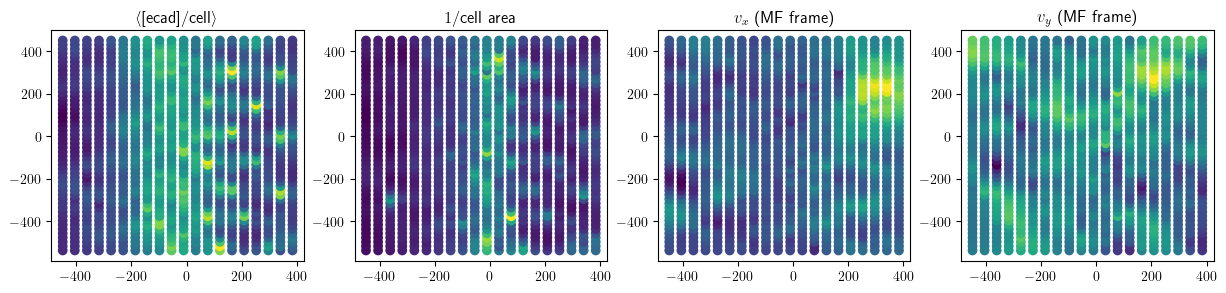

In [16]:
mesh_points = np.vstack([xgrid.reshape(-1), ygrid.reshape(-1)]).T
fig,axs=plt.subplots(1,4, figsize=(15,3))
axs[0].scatter(mesh_points[:,0], mesh_points[:,1], c = ecad_rbf(mesh_points))
axs[1].scatter(mesh_points[:,0], mesh_points[:,1], c = dens_rbf(mesh_points))
axs[2].scatter(mesh_points[:,0], mesh_points[:,1], c = vx_rbf(mesh_points))
axs[3].scatter(mesh_points[:,0], mesh_points[:,1], c = vy_rbf(mesh_points))

axs[0].set_title(r'$\langle$[ecad]/cell$\rangle$')
axs[1].set_title(r'$1/$cell area')
axs[2].set_title(r'$v_x$ (MF frame)')
axs[3].set_title(r'$v_y$ (MF frame)')

plt.show()


In [26]:
obs_full    = np.array([ecad_tot[:nt]/npix[:nt], npix[:nt], vx_mf[:nt], vy_mf[:nt], aspect_ratio[:nt]])
nobs        = obs_full.shape[0]
rbf_t       = []
ts          = np.arange(nt)
for t in ts:
    
    # compute the interpolations
    idxs        = ~np.isnan(vx_mf[t])
    obs_t       = obs_full[:,t,idxs].T
    rbf_t.append(RBFInterpolator(mf_pos[t,idxs], obs_t, kernel = kernel_type))

In [116]:
dx_fine = 4
dy_fine = 4
xlim = np.array([-400,400])
ylim = np.array([-400,400])

xs_fine = np.arange(xlim[0], xlim[1]+dx_fine, dx_fine)
ys_fine = np.arange(ylim[0], ylim[1]+dy_fine, dy_fine)

xgrid_fine, ygrid_fine   = np.meshgrid(xs_fine,ys_fine)
xygrid_fine              = np.array(np.meshgrid(xs_fine,ys_fine))
xy_points                = xygrid_fine.reshape(2,-1).T
_,nx,ny                  = xygrid_fine.shape


obs_grid  = np.array([rbf(xy_points) for rbf in rbf_t]) # takes a couple minutes... for 200*200 = 40000 points
obs_grid  = obs_grid.reshape(nt, xygrid_fine.shape[1], xygrid_fine.shape[2], nobs).transpose((0,2,1,3)) 

In [227]:
dx_big      = 30
dx_idx      = int(np.around(dx_big / dx_fine))


xs       = np.arange(xlim[0], xlim[1], int(dx_big/4))
xidxs    = np.array([coord2idx(x, nx, xlim) for x in xs])
obs_x_mu = np.array([np.mean(obs_grid[:,x_idx:x_idx+dx_idx], axis=1) for x_idx in xidxs]).transpose((1,0,2,3))

In [228]:
#dyi = 0
#dys         = np.array([5,10, 20, 50, 100,200])
dys         = np.hstack([np.arange(5,10),10*np.arange(1,10), 100+10*np.arange(1,21)])

dy_idxs     = np.array(np.around(dys / dy_fine), dtype='int') # get as close as possible to the desired dy
dy_idxs     = np.sort(np.unique(dy_idxs))
dys         = dy_idxs*dy_fine                                 # but correct for the actual dy
# compute eigenvalue decomp at different length scales
obs_x_mu_dy = [np.array([np.mean(obs_x_mu[:,:,y_idx:y_idx+dy_idx], axis=2)
                        for y_idx in range(0, obs_x_mu.shape[2]-dy_idx,dy_idx)]) 
               for dy_idx in dy_idxs]

# compute eigenvalue decomp at different length scales 
# have to fix this so that it uses the same number of samples for each length scale
# so basically, take the largest length scale and determine how many boxes it'll have
# then resample all the other length scales using that number of boxes

nsamples = 3 # ??? seems ridiculously low
             # could still convolve with 
obs_x_mu_dy = [np.array([np.mean(obs_x_mu[:,:,y_idx:y_idx+dy_idx], axis=2)
                        for y_idx in range(0, obs_x_mu.shape[2]-dy_idx,dy_idx)]) 
               for dy_idx in dy_idxs]

# obs_x_mu_dy = [np.array([np.mean(obs_x_mu[:,:,y_idx:y_idx+dy_idx], axis=2)
#                         for y_idx in range(0, obs_x_mu.shape[2]-dy_idx,1)]) #.transpose((1,2,0,3)) 
#                for dy_idx in dy_idxs]
nsamp = [x.shape[0] for x in obs_x_mu_dy];

In [229]:
obs_x_mu_dy_n = [x/np.sum(x,axis=0) for x in obs_x_mu_dy]
#obs_x_mu_dy_n = [x/np.sum(x,axis=0) for x in obs_x_mu_dy]

In [230]:
xmins = np.nanmin(xdist_mu[0:-1],axis=1)
xmaxs = np.nanmax(xdist_mu[0:-1],axis=1)

# for each x, only include ts where there's data for that x
# i.e., t for which x is greater than the min xdist(t) and 
#.      t for which x is smaller than     max xdist(t)
ts_per_x_dict = {x:np.where((x>xmins) & (x<xmaxs)) for x in xs}
ts_per_x      = [np.where((x>xmins) & (x<xmaxs))[0] for x in xs]

In [231]:
obs_vars = np.array(list(map(lambda x: np.var(x, axis=0), obs_x_mu_dy_n)))
obs_mu   = np.array(list(map(lambda x: np.mean(x, axis=0), obs_x_mu_dy_n)))

obs_vars_mu   = np.array([meanOrNan(obs_vars[:,ts_per_x[xi],xi], axis=1) for xi in range(len(xs))]).transpose((1,0,2))
obs_vars_mu_n = (obs_vars_mu.transpose((1,2,0))*nsamp).transpose((2,0,1))

In [ ]:
# does the length scale of the peak of the variance make sense?
# does it match the fft length scale?


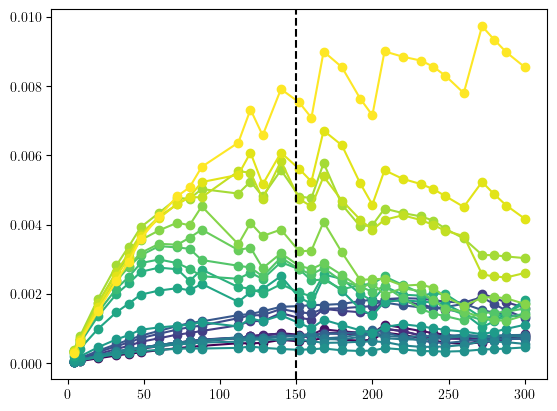

In [236]:
fig,axs=plt.subplots()
xxs = np.arange(0,xs.shape[0],5)
cols = plt.cm.viridis(np.linspace(0,1,len(xxs)))
for i,xxi in enumerate(xxs):
    axs.plot(dys, obs_vars_mu_n[:,xxi,0],'o-', color = cols[i])

# vls = [120, 140,170, 210, 270]
# for v in vls:
#     axs.axvline(v)
axs.axvline(150,color='k',linestyle='--')
#axs.set_yscale('symlog',linthresh=1e-3)
#axs.set_xlim(10,300)
plt.show()

In [233]:
obss  = np.array([0,1])
evals = np.array([[[PCA().fit(obs_x_mu_dy_n[dyi][:,ti, dxi,obss]).explained_variance_[0:2]
                    for dxi in range(obs_x_mu_dy_n[dyi].shape[2])]
                   for ti in range(obs_x_mu_dy_n[dyi].shape[1])]
                  for dyi in range(len(obs_x_mu_dy_n))])

In [ ]:
meanOrNan   = lambda x, axis: np.mean(x, axis) if np.shape(x)[axis] > 0 else np.zeros(x.shape[1:])+np.nan
eig0_mu_t   = np.array([meanOrNan(evals[:,ts_per_x[xi],xi], axis=1) for xi in range(len(ts_per_x))]).transpose((1,0,2))
eig0_mu_t_n = (eig0_mu_t.transpose((1,2,0))*nsamp).transpose((2,0,1))

In [ ]:
ny = obs_x_mu.shape[2]

ecad_ffts      = [[np.fft.fftfreq(ny,dy_fine),np.fft.fft(obs_x_mu[ts_per_x[xi],xi,:,0])]
                  for xi in range(obs_x_mu.shape[1])]
ecad_fft_mu  = np.array([np.mean(np.abs(f[1]), axis=0) for f in ecad_ffts])
ecad_fft_std = np.array([np.std(np.abs(f[1]), axis=0) for f in ecad_ffts])
fft_freqs = np.fft.fftfreq(ny,np.diff(ylim)/ny)
fidxs = np.arange(1,int(len(fft_freqs)/2))

In [ ]:
fig,axs   = plt.subplots(2,3,figsize=(15,8))

dxx = 10
xxs = np.arange(0,int(xs.shape[0]/2),dxx)
cols = plt.cm.viridis(np.linspace(0,1,xxs.shape[0]))
for i,xx in enumerate(xxs):
    
    axs[0,0].plot(dys, obs_vars_mu_n[:,xx,0], 'o-', color=cols[i], label = xs[xx])
    axs[0,1].plot(dys, eig0_mu_t_n[:,xx,0], 'o-', color=cols[i], label = xs[xx])
    axs[0,2].plot(0.5/fft_freqs[fidxs], ecad_fft_mu[xx,fidxs], 'o-', color=cols[i], label = xs[xx])

xxs = np.arange(int(xs.shape[0]/2),xs.shape[0],dxx)
cols = plt.cm.viridis(np.linspace(0,1,xxs.shape[0]))
for i,xx in enumerate(xxs):
    
    axs[1,0].plot(dys, obs_vars_mu_n[:,xx,0], 'o-', color=cols[i], label = xs[xx])
    axs[1,1].plot(dys, eig0_mu_t_n[:,xx,0], 'o-', color=cols[i], label = xs[xx])
    axs[1,2].plot(0.5/fft_freqs[fidxs], ecad_fft_mu[xx,fidxs], 'o-', color=cols[i], label = xs[xx])

    
#axs.set_xscale('log')
axs[0,2].legend(title='dist from furrow', loc=(1,0), ncol=2)
axs[1,2].legend(title='dist from furrow', loc=(1,0), ncol=2)

#axs.set_yscale('symlog',linthresh=1e-7)

for ax in axs.reshape(-1):
    ax.set_xscale('log')
    ax.set_xlim(3,600)
axs[0,1].set_yscale('log')
axs[1,1].set_yscale('log')

ttls = ['ecad variance', 'cov eval 1', 'FFT']
for i in range(len(ttls)):
    axs[0,i].set_title(ttls[i])
    axs[1,i].set_xlabel('length scale (pixels)')
    
# cbar = plt.colorbar(sm, cax=cax)
# ctix = np.linspace(0,1,6)
# cbar.set_ticks(ctix)
# cbar.set_ticklabels(['{0:.0f}'.format(d) 
#                      for d in np.hstack([ap_mf_dist[np.array(ctix[0:-1]*ap_mf_dist.shape[0], dtype='int')], 
#                                ap_mf_dist[-1]])])
# cax.set_ylabel(r'dist from morphogenetic furrow',rotation = 270, labelpad = 15)

#axs.set_xlim(xmin=3)
#axs.set_ylim(ymin=0,ymax=5e-6)
#axs.set_yscale('log')
plt.show()

In [17]:
# evaluate all observables in fine grid at every point in time
# use fine grid to measure average observables in bins [x,x+dx],[y, y+dy] (sliding windows)
# at each time obtain C(x,dy,t) = the covariance of the features ecad, density, vx, vy at a particular x position
#                               and particular length scale dy
# average over time (where exists) to obtain C(x,dy)
# may be better to replace with eig_cov

In [19]:
xygrid_fine.shape

(2, 1201, 1201)

In [20]:

kernel_type = 'linear'

ecad_rbf    = RBFInterpolator(mf_pos[t,idxs], ecad_tot[t,idxs]/npix[t,idxs], kernel = kernel_type)
dens_rbf    = RBFInterpolator(mf_pos[t,idxs], 1/npix[t,idxs],                kernel = kernel_type)
vx_rbf      = RBFInterpolator(mf_pos[t,idxsv], vx_mf[t,idxsv],               kernel = kernel_type)
vy_rbf      = RBFInterpolator(mf_pos[t,idxsv], vy_mf[t,idxsv],               kernel = kernel_type)

xs         = np.linspace(pos_min[0], pos_max[0], nbinx) 
ys         = np.linspace(pos_min[1], pos_max[1], nbiny) 

In [372]:
m = RBFInterpolator(mf_pos[t,idxs], 
                    np.vstack([ecad_tot[t,idxs]/npix[t,idxs], 1/npix[t,idxs]]).T, 
                    kernel = kernel_type)
m(np.array([[0,0]]))

array([[4.26594047e+01, 2.29675742e-03]])

In [371]:
np.vstack([ecad_tot[t,idxs]/npix[t,idxs], 1/npix[t,idxs]]).shape

(2, 467)

In [180]:
# all observations at time t
xy_points = xygrid_fine.reshape(2,-1).T
obs_mat   = np.array([ecad_rbf(xy_points), dens_rbf(xy_points), vx_rbf(xy_points), vy_rbf(xy_points)])
obs_mat   = obs_mat.reshape(4, xygrid_fine.shape[1], xygrid_fine.shape[2])

In [196]:
obs_mat.shape

(4, 1201, 1201)

In [213]:
x           = -400
y           = -600
dx_big      = 20
dy_big      = 20
t           = 1

# where is x ?
_,nx,ny  = xygrid_fine.shape
dx_idx = int(np.around(dx_big / dx_fine))
dy_idx = int(np.around(dy_big / dy_fine))

coord2idx = lambda coord, nidx, lims : int(np.around(nidx * (coord - lims[0]) / (lims[1]-lims[0])))

x_idx  = coord2idx(x, nx, xlim) #int(np.around(nx * (x - xlim[0]) / (xlim[1]-xlim[0])))
y_idx  = coord2idx(y, ny, ylim)

# at each time obtain C(x,dy,t) = the covariance of the features ecad, density, vx, vy at a particular x position
#                               and particular length scale dy
obs_x    = obs_mat[:,x_idx:x_idx+dx_idx]
obs_x_mu = np.mean(obs_x, axis=1)


obs_x_mu_dy = np.array([np.mean(obs_mat_x_mu[:,y_idx:y_idx+dy_idx], axis=1) for y_idx in range(0, ny-dy_idx)])

# normalize so that features all sum to 1
obs_x_mu_dy = obs_x_mu_dy / np.sum(obs_x_mu_dy, axis=0)
eigs        = pca.fit(obs_x_mu_dy).explained_variance_

In [352]:
dys         = np.hstack([np.arange(1,10),np.arange(10,100,10),np.arange(100,1000,100)])
dys.shape


(27,)

In [391]:
obs_t.shape, len(idxs),obs_full.shape,np.where(idxs)[0].shape, 

((730, 5), 1055, (5, 116, 1055), (730,))

In [441]:
obs_x_mu_dy

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [483]:
# initialize the full grid
xlim    = np.array([-400,400])
ylim    = np.array([-400,400])
dx_fine = 2
dy_fine = 2
xs_fine = np.arange(xlim[0], xlim[1]+dx_fine, dx_fine)
ys_fine = np.arange(ylim[0], ylim[1]+dy_fine, dy_fine)
xygrid_fine = np.array(np.meshgrid(xs_fine,ys_fine))
xy_points   = xygrid_fine.reshape(2,-1).T
nx = xs_fine.shape[0]
ny = ys_fine.shape[0]


# setup the loop variables
dx_big      = 20 
dx_idx      = int(np.around(dx_big / dx_fine))
dx_step     = int(dx_idx / 2)
xmin        = xlim[0]
xmax        = xlim[1]
xs          = np.arange(xmin, xmax, dx_idx)
xmids       = xs + dx_step
dys         = np.array([5,10, 20, 50, 100,200,500])
dy_idxs     = np.array(np.around(dys / dy_fine), dtype='int') # get as close as possible to the desired dy
dys         = dy_idxs*dy_fine                                 # but correct for the actual dy

#dys         = np.hstack([np.arange(1,10),np.arange(10,100,10),np.arange(100,1000,100)])

ts          = np.arange(nt)

# rbf params
kernel_type = 'linear'

nt           = vx_mf.shape[0]
obs_full     = np.array([ecad_tot[:nt]/npix[:nt], npix[:nt], vx_mf[:nt], vy_mf[:nt], aspect_ratio[:nt]])
nobs         = obs_full.shape[0]

# outputs 
eigs    = np.zeros((ts.shape[0], xs.shape[0], dys.shape[0], nobs))
nsamp   = np.zeros((ts.shape[0], xs.shape[0], dys.shape[0]))

# outdir  = '{0}/eig'.format(datdir)
# os.makedirs(outdir, exist_ok=True)
# os.makedirs('{0}/evals'.format(outdir), exist_ok=True)
# os.makedirs('{0}/nsamp'.format(outdir), exist_ok=True)


# np.save('{0}/xmids.npy'.format(outdir), xmids)
# np.save('{0}/dys.npy'.format(outdir), dys)

for t in ts:
    
    # compute the interpolations
    #idxs        = ~np.isnan(ecad_tot[t])
    idxs        = ~np.isnan(vx_mf[t])
    obs_t       = obs_full[:,t,idxs].T
    obs_rbf     = RBFInterpolator(mf_pos[t,idxs], obs_t, kernel = kernel_type) # 40 ms
    obs         = obs_rbf(xy_points) # 10 s ==> bottleneck ?
    obs         = obs.reshape(xygrid_fine.shape[1], xygrid_fine.shape[2],nobs).transpose((2,0,1)) # 20 us
    
    print('\nt = {0}'.format(t))
    
    for xi, x in enumerate(xs):
        
        # average over the width of the "column"
        x_idx    = coord2idx(x, nx, xlim)
        obs_x    = obs[:,x_idx:x_idx+dx_idx]
        obs_x_mu = np.mean(obs_x, axis=1) 
        
        for dyi, dy_idx in enumerate(dy_idxs):
            
            # compute eigenvalue decomp at different time scales
            obs_x_mu_dy = np.array([np.mean(obs_x_mu[:,y_idx:y_idx+dy_idx], axis=1) 
                                    for y_idx in range(0, obs_x_mu.shape[1]-dy_idx)])
            obs_x_mu_dy = obs_x_mu_dy / np.sum(obs_x_mu_dy, axis=0)

            nsamp[t,xi,dyi] = obs_x_mu_dy.shape[0]
            pca             = PCA()
            eigs[t,xi,dyi]  = pca.fit(obs_x_mu_dy).explained_variance_

    
#     np.save('{0}/evals/t{1}.npy'.format(outdir, t), eigs[t])
#     np.save('{0}/nsamp/t{1}.npy'.format(outdir, t), nsamp[t])

    


t = 0

t = 1

t = 2

t = 3

t = 4

t = 5

t = 6

t = 7

t = 8

t = 9

t = 10

t = 11

t = 12

t = 13

t = 14

t = 15

t = 16

t = 17

t = 18

t = 19

t = 20

t = 21

t = 22

t = 23

t = 24

t = 25

t = 26

t = 27

t = 28

t = 29

t = 30

t = 31

t = 32

t = 33

t = 34

t = 35

t = 36

t = 37

t = 38

t = 39

t = 40

t = 41

t = 42

t = 43

t = 44

t = 45

t = 46

t = 47

t = 48

t = 49

t = 50

t = 51

t = 52

t = 53

t = 54

t = 55

t = 56

t = 57

t = 58

t = 59

t = 60

t = 61

t = 62

t = 63

t = 64

t = 65

t = 66

t = 67

t = 68

t = 69

t = 70

t = 71

t = 72

t = 73

t = 74

t = 75

t = 76

t = 77

t = 78

t = 79

t = 80

t = 81

t = 82

t = 83

t = 84

t = 85

t = 86

t = 87

t = 88

t = 89

t = 90

t = 91

t = 92

t = 93

t = 94

t = 95

t = 96

t = 97

t = 98

t = 99

t = 100

t = 101

t = 102

t = 103

t = 104

t = 105

t = 106

t = 107

t = 108

t = 109

t = 110

t = 111

t = 112

t = 113

t = 114

t = 115


In [501]:
m = obs_rbf(xy_points)

In [514]:
m1 = m.reshape(nobs, xygrid_fine.shape[1], xygrid_fine.shape[2])
m2 = m.reshape(xygrid_fine.shape[1], xygrid_fine.shape[2], nobs).transpose((2,0,1))

In [507]:
np.array_equal(m1.shape, m2.transpose((2,0,1)).shape)

True

In [526]:
# x = 399
# x_idx = coord2idx(x, nx, xlim)
# x_idx

400

In [1089]:
obs_t.shape, obs_x_mu.shape

((116, 401, 401, 5), (116, 32, 401, 5))

In [1178]:
[x.shape for x in obs_x_mu_dy_n]

[(399, 116, 32, 5),
 (398, 116, 32, 5),
 (199, 116, 32, 5),
 (198, 116, 32, 5),
 (79, 116, 32, 5),
 (56, 116, 32, 5),
 (39, 116, 32, 5),
 (32, 116, 32, 5),
 (25, 116, 32, 5),
 (22, 116, 32, 5),
 (19, 116, 32, 5),
 (17, 116, 32, 5),
 (15, 116, 32, 5),
 (7, 116, 32, 5)]

In [1157]:
obs_vars_mu_n.shape

(14, 32, 5)

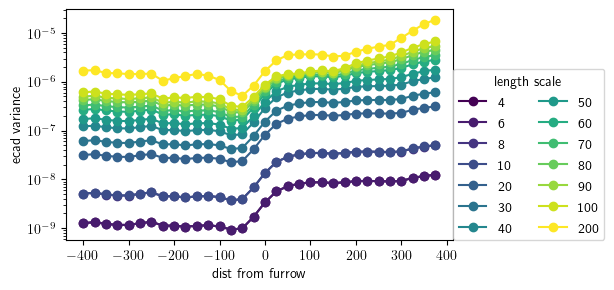

In [1198]:
fig,axs=plt.subplots(figsize=(5,3))
#axs.plot(dys, obs_vars_mu_n[:,10,0],'ko-')
cols = plt.cm.viridis(np.linspace(0,1,dys.shape[0]))

for i in range(len(dys)):
    axs.plot(xs, obs_vars_mu_n[i,:,0],'o-',label=dys[i], color=cols[i])

#axs.set_xscale('symlog')
#axs.legend(loc=(1,0))
axs.set_yscale('log')
axs.legend(title='length scale', loc=(1,0), ncol=2)
axs.set_ylabel('ecad variance')
axs.set_xlabel('dist from furrow')
plt.show()
#axs[0,0].plot(dys, obs_vars_mu_n[:,xx,3], 'o-', color=cols[i], label = xs[xx])


In [1150]:
obs_vars_mu_n.shape[0]

14

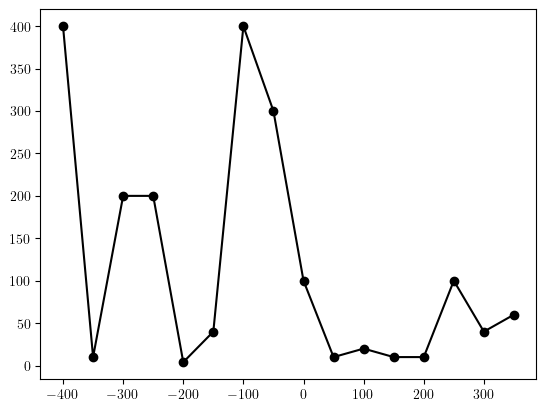

In [811]:
fig,axs=plt.subplots()
axs.plot(xs, dys[np.argmax(eig0_mu_t[:,:,0],axis=0)],'ko-')
plt.show()

In [1220]:
xs[::4], ny,ylim,np.arange(0,ny,50),np.arange(ylim[0],ylim[1]+50,50*dy_fine)

(array([-400, -300, -200, -100,    0,  100,  200,  300]),
 401,
 array([-400,  400]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400]),
 array([-400, -300, -200, -100,    0,  100,  200,  300,  400]))

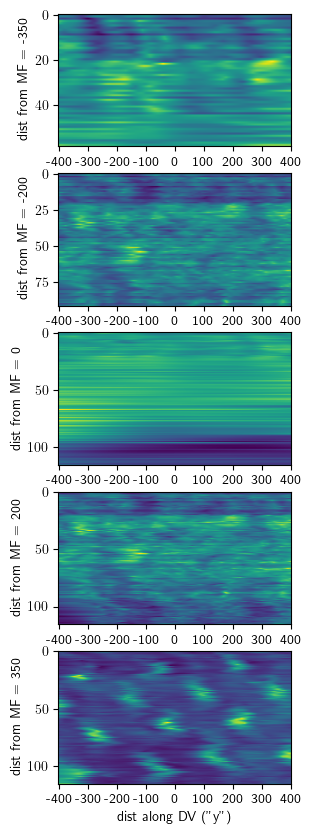

In [1225]:
fig,axs=plt.subplots(5,1, figsize=(3,10))

xxs = [-350,-200,0,200,350]
for i in range(len(xxs)):
    x  = xxs[i]
    xi = np.where((xs[:-1]<=x) & (xs[1:]>=x))[0][0]
    axs[i].imshow(obs_t[ts_per_x[xi],x,:,0],aspect='auto')
    axs[i].set_xticks(np.arange(0,ny,50))
    
    axs[i].set_xticklabels(np.arange(ylim[0],ylim[1]+50,50*dy_fine))
    axs[i].set_ylabel('dist from MF = {0}'.format(x))

axs[-1].set_xlabel('dist along DV ("y")')


plt.show()

In [820]:
[len(t) for t in ts_per_x]

[52, 62, 76, 88, 98, 109, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]

In [1165]:
obs_vars.shape

(14, 116, 32, 5)

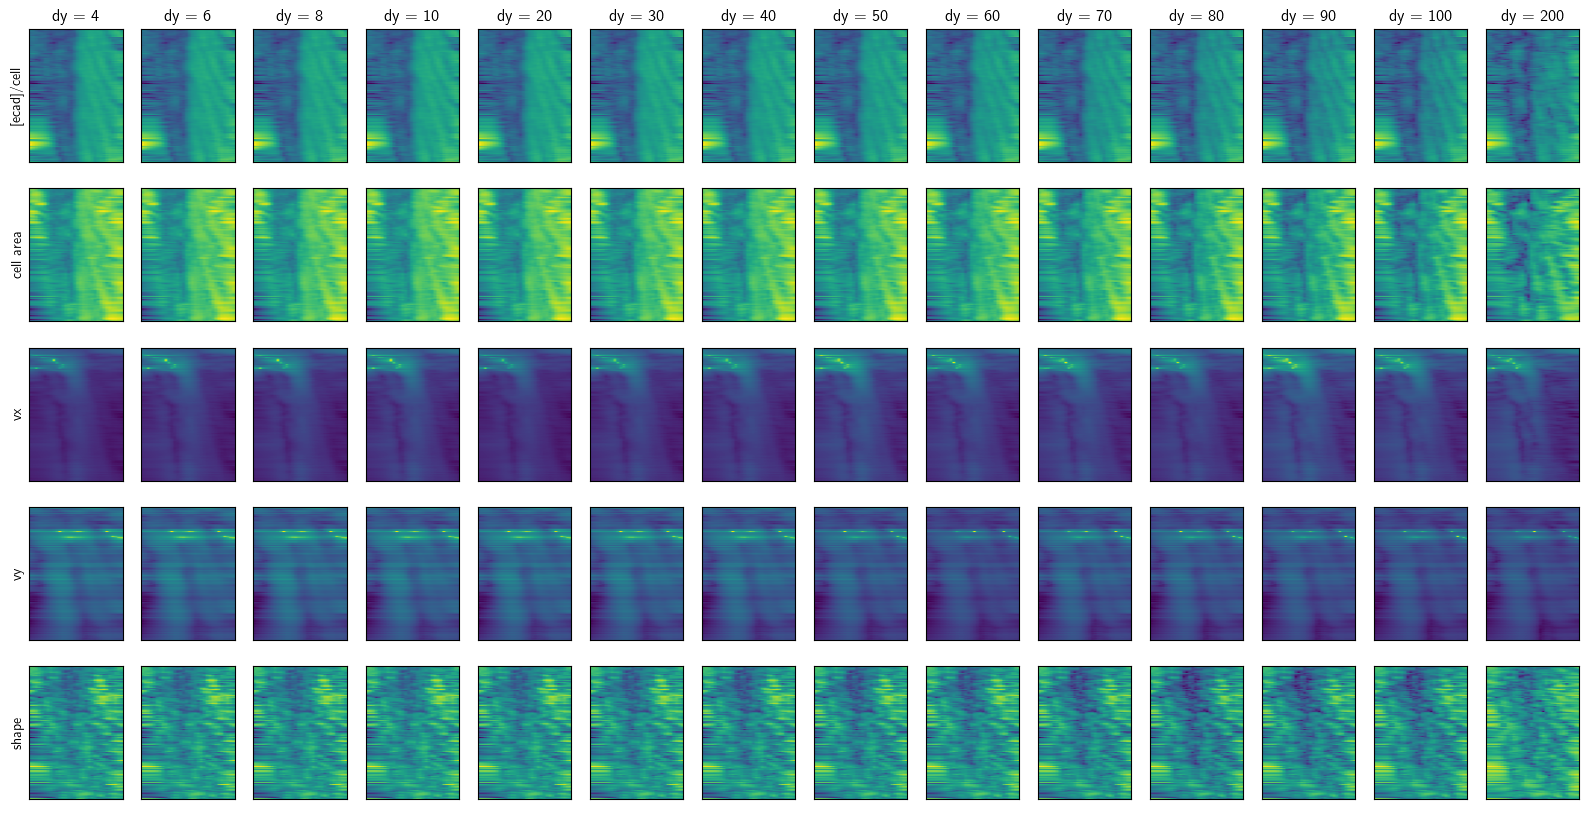

In [1230]:
fig,axs=plt.subplots(nobs,len(dys),figsize=(20,10))
for i in range(len(dys)):
    axs[0,i].set_title('dy = {0}'.format(dys[i]))
    for j in range(nobs):
        axs[j,i].imshow(np.log10(obs_vars[i,:,:,j]),aspect='auto')
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])

obs_names = ['[ecad]/cell','cell area','vx','vy','shape']
for i in range(nobs):
    axs[i,0].set_ylabel(obs_names[i])

    

plt.show()

In [829]:
obs_x_mu.shape

(116, 16, 401, 5)

In [834]:
ecad_fft_mu.shape

(16, 401)

In [590]:
fig,axs=plt.subplots()


(7, 116, 80, 5)

In [580]:
m1 = np.random.rand(4,4)
m2 = np.random.rand(4,4)
m1,m2

(array([[0.77858985, 0.57304652, 0.56977504, 0.56723502],
        [0.15259004, 0.56883078, 0.67947446, 0.31098262],
        [0.4662755 , 0.60258598, 0.00156902, 0.38410499],
        [0.65962293, 0.38063085, 0.04123211, 0.33455549]]),
 array([[0.61176937, 0.13584853, 0.02403832, 0.50300403],
        [0.62214495, 0.78052862, 0.16728186, 0.94208871],
        [0.61228742, 0.25382244, 0.56099108, 0.13624934],
        [0.92830841, 0.86246314, 0.07069528, 0.99746674]]))

In [587]:
k = [PCA().fit(m).explained_variance_ for m in [m1,m2]]
k

[array([1.39857278e-01, 7.15026852e-02, 1.06901568e-02, 4.41411272e-33]),
 array([3.11364641e-01, 5.70347944e-02, 1.39138436e-02, 8.41203281e-33])]

In [576]:
mypca = lambda m, ax: PCA().fit(m).explained_variance_


TypeError: <lambda>() takes 1 positional argument but 2 were given

In [575]:
i = 0
j = 0
mypca(obs_x_mu_dy_n[0])

ValueError: Found array with dim 4. Estimator expected <= 2.

In [529]:
for xi, x in enumerate(xs):

    # average over the width of the "column"
    x_idx    = coord2idx(x, nx, xlim)
    obs_x    = obs[:,x_idx:x_idx+dx_idx]
    obs_x_mu = np.mean(obs_x, axis=1)

    for dyi, dy_idx in enumerate(dy_idxs):

        # compute eigenvalue decomp at different time scales
        obs_x_mu_dy = np.array([np.mean(obs_x_mu[:,y_idx:y_idx+dy_idx], axis=1) 
                                for y_idx in range(0, obs_x_mu.shape[1]-dy_idx)])
        obs_x_mu_dy = obs_x_mu_dy / np.sum(obs_x_mu_dy, axis=0)

        nsamp[t,xi,dyi] = obs_x_mu_dy.shape[0]
        pca             = PCA()
        eigs[t,xi,dyi]  = pca.fit(obs_x_mu_dy).explained_variance_

KeyboardInterrupt: 

In [425]:
%time obs_rbf     = RBFInterpolator(mf_pos[t,idxs], obs_t, kernel = kernel_type) # 40 ms

#obs_t       = obs_full[:,t,idxs].

CPU times: user 5.14 ms, sys: 735 µs, total: 5.88 ms
Wall time: 36.8 ms


In [439]:
%time obs         = obs_rbf(xy_points[0:1000000]) # 10 s

CPU times: user 5.37 s, sys: 80 ms, total: 5.45 s
Wall time: 6.1 s


In [432]:
%time m=xy_points**2

CPU times: user 5.03 ms, sys: 3.37 ms, total: 8.4 ms
Wall time: 7.23 ms


In [428]:
xy_points.shape

(1442401, 2)

In [427]:
%time obs         = obs.reshape(nobs, xygrid_fine.shape[1], xygrid_fine.shape[2]) #20us


CPU times: user 12 µs, sys: 4 µs, total: 16 µs
Wall time: 18.8 µs


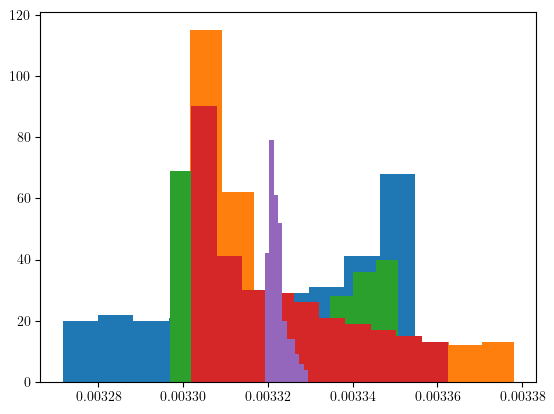

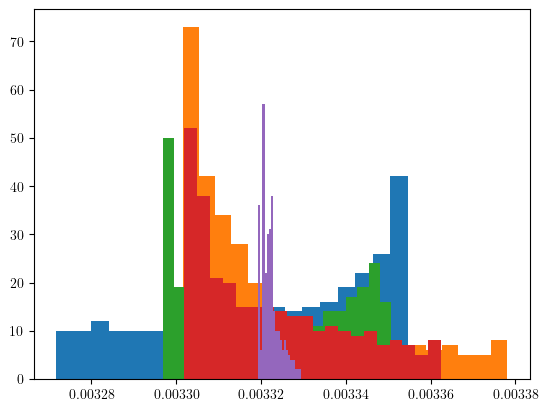

In [403]:
#np.sum(obs_x_mu_dy)
fig,axs=plt.subplots()
for i in np.arange(nobs):
    axs.hist(obs_x_mu_dy[:,i], bins=20)
plt.show()

In [321]:
xi=15
ts_per_x[xi]
eigs[ts_per_x[xi]].shape, meanOrNan(eigs[ts_per_x[xi]], axis=0).shape, np.mean(eigs[ts_per_x[xi]], axis=0).shape

((24, 120, 10, 4), (120, 10, 4), (120, 10, 4))

In [305]:
eigs.shape

(116, 120, 10, 4)

In [307]:
np.mean(eigs[np.arange(4)],axis=0).shape

(120, 10, 4)

In [277]:
xmins[[20,32,33]],xmaxs[[20,32,33]]

(array([-473.86984673, -474.94574762, -470.61703063]),
 array([372.21538846, 377.67091087, 375.33840106]))

In [214]:
pca = PCA()
pca.fit(obs_x_mu_dy).explained_variance_
# eigs = [np.array([pca.fit(obs_mat_x_mu_dy).explained_variance_
#                   for t in range(len(obs_mats[i]))])
#         for i in range(len(obs_mats))]

array([4.35391611e-07, 2.96451762e-07, 2.01654191e-07, 9.98842945e-09])

In [212]:
np.sum(obs_x_mu_dy/np.sum(obs_x_mu_dy,axis=0),axis=0)

array([1., 1., 1., 1.])

In [191]:
x_idx, x_idx + dx_idx

(200, 220)

In [193]:
obs_mat.shape

(4, 1201, 1201)

In [177]:
a = np.random.rand(2,3,4)
#a
aflat    = a.reshape(2,-1)
anonflat = aflat.reshape(a.shape)
np.array_equal(anonflat, a)

True